In [2]:
if sc:
    sc.stop()

In [3]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("22125094_lab5")
sc = SparkContext(conf = conf)

sc.getConf().getAll()

[('spark.app.submitTime', '1765041570650'),
 ('spark.driver.appUIAddress', 'http://edge:4051'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spar

Retrieve data.

In [ ]:
train = sc.textFile("hdfs://name:9000/Lab5_Datasets/medium_housing_train.csv")
test = sc.textFile("hdfs://name:9000/Lab5_Datasets/housing_test.csv")

# train.collect()

In [ ]:
header_train = train.first()
train = train.filter(lambda x : x != header_train)
header_test = test.first()
test = test.filter(lambda x : x != header_test)
# train.collect()

In [ ]:
def parsing(line):
    parts = line.split(',')
    return (float(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]))

train_parsed = train.map(parsing)
test_parsed = test.map(parsing)

# train_parsed.collect()

In [40]:
train_kv = train_parsed.map(lambda x : (0, (x[:-1], x[-1])))
train_kv = train_kv.repartition(20)

test_kv = test_parsed.map(lambda x: (0, (x[:-1], x[-1])))

train_kv.take(10)

[(0, ((125.95, 1.0, 3.43, 17.0), 141974.07)),
 (0, ((74.23, 3.0, 7.14, 13.0), 33604.61)),
 (0, ((159.41, 4.0, 9.07, 38.0), 26095.96)),
 (0, ((109.95, 6.0, 16.64, 40.0), 107885.07)),
 (0, ((89.49, 6.0, 2.99, 38.0), 113749.32)),
 (0, ((72.04, 7.0, 1.59, 6.0), 130772.35)),
 (0, ((51.46, 6.0, 4.32, 38.0), 33617.34)),
 (0, ((92.71, 5.0, 18.61, 30.0), 106198.37)),
 (0, ((49.47, 7.0, 5.75, 12.0), 10000.0)),
 (0, ((127.89, 4.0, 12.5, 29.0), 79391.35))]

In [61]:
NUM_FEATURES = 4
NUM_BUCKETS = 20
SAMPLE_SIZE = 50000
# ROOT_ID = 0
# BIG_NODES = {ROOT_ID}

In [62]:
import random

# Vitter reservoir sampling on partition
def reservoir_sample_partition(partition):
    sample = []
    count = 0

    for v in partition:
        count += 1
        if len(sample) < SAMPLE_SIZE:
            sample.append(v)
        else:
            j = random.randint(0, count - 1)
            if j < SAMPLE_SIZE:
                sample[j] = v

    return sample

In [63]:
candidate_splits = {}

for f in range(NUM_FEATURES):
    feature_rdd = train_kv.map(lambda z: z[1][0][f])
    local_samples = feature_rdd.mapPartitions(lambda partition: [reservoir_sample_partition(partition)])
    global_samples = local_samples.flatMap(lambda x: x).collect()
    global_samples.sort()
    step = len(global_samples) / NUM_BUCKETS
    splits = []
    for j in range(1, NUM_BUCKETS):
        idx = int(j * step)
        if idx < len(global_samples):
            splits.append(global_samples[idx])
    candidate_splits[f] = sorted(list(set(splits)))
    
candidate_splits

{0: [38.49,
  46.84,
  55.29,
  63.83,
  72.38,
  80.85,
  89.33,
  97.81,
  106.34,
  114.82,
  123.38,
  131.86,
  140.32,
  148.83,
  157.34,
  165.94,
  174.47,
  182.9,
  191.49],
 1: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
 2: [2.47,
  3.91,
  5.33,
  6.8,
  8.27,
  9.71,
  11.16,
  12.6,
  14.06,
  15.5,
  16.97,
  18.42,
  19.87,
  21.27,
  22.73,
  24.17,
  25.63,
  27.09,
  28.54],
 3: [2.0,
  4.0,
  6.0,
  8.0,
  10.0,
  12.0,
  14.0,
  16.0,
  18.0,
  20.0,
  22.0,
  24.0,
  26.0,
  28.0,
  30.0,
  32.0,
  34.0,
  36.0,
  38.0]}

MR_ExpandNodes

In [64]:
from collections import defaultdict

def mr_expandnodes_map(partition):
    agg_tup_n = defaultdict(lambda: [0.0, 0.0, 0])
    T = defaultdict(lambda: [0.0, 0.0, 0])
    for line in partition:
        n, (x, y) = line
        if n not in BIG_NODES:
            continue
        sy = y
        sy2 = y * y
        agg = agg_tup_n[n]
        agg[0] += sy
        agg[1] += sy2
        agg[2] += 1
        for f in range(NUM_FEATURES):
            v = x[f]
            for s in candidate_splits[f]:
                if s < v:
                    key = (n, f, float(s))
                    t = T[key]
                    t[0] += sy
                    t[1] += sy2
                    t[2] += 1
    for n, (sumY, sumY2, count) in agg_tup_n.items():
        yield (("TOTAL", n), (sumY, sumY2, count))
    for (n, f, s), (sumY, sumY2, count) in T.items():
        yield ((n, f, s), (sumY, sumY2, count))

In [65]:
def mr_expandnodes(train_kv):
    mapped = train_kv.mapPartitions(mr_expandnodes_map)
    stats = mapped.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])).collect()
    return stats

In [66]:
def variance(sy, sy2, n):
    if n == 0:
        return 0.0
    mean = sy / n
    return sy2 / n - mean * mean

def best_split(stats):
    total_n   = {}
    split_map = defaultdict(list)
    for key, val in stats:
        if key[0] == "TOTAL":
            _, n = key
            total_n[n] = val
        else:
            n, f, s = key
            split_map[n].append((f, s, val))
            
    best_split_for_node = {}
    for n in total_n:
        T_sy, T_sy2, T_n = total_n[n]
        var_before = variance(T_sy, T_sy2, T_n)
        best_gain = float("-inf")
        best_info = None
        for f, s, (l_sy, l_sy2, l_n) in split_map[n]:
            r_sy = T_sy - l_sy
            r_sy2 = T_sy2 - l_sy2
            r_n = T_n - l_n
            if l_n == 0 or r_n == 0:
                continue
            var_left  = variance(l_sy, l_sy2, l_n)
            var_right = variance(r_sy, r_sy2, r_n)
            gain = var_before - (l_n / T_n) * var_left - (r_n / T_n) * var_right
            if gain > best_gain:
                best_gain = gain
                best_info = {
                    "feature": f,
                    "split": s,
                    "gain": gain,
                    "left":  (l_sy, l_sy2, l_n),
                    "right": (r_sy, r_sy2, r_n)
                }
        best_split_for_node[n] = best_info
    return best_split_for_node

MR_InMemory

In [67]:
MAX_DEPTH = 8
MIN_LEAF_SIZE = 50


In [68]:
def mr_inmemory_map(partition):
    for line in partition:
        n, (x, y) = line
        if n not in SMALL_NODES:
            continue
        yield (n, (x, y))

In [69]:
class InMemoryNode:
    def __init__(self, depth=0):
        self.depth = depth
        self.feature = None
        self.split = None
        self.left = None
        self.right = None
        self.value = None
        
def inmemory_split(data):
    y = [val for _, val in data]
    sy = sum(y)
    sy2 = sum(i * i for i in y)
    n = len(data)
    if n == 0: 
        return None
    var_before = variance(sy, sy2, n)
    best_gain = float("-inf")
    best_info = None
    for f in range(NUM_FEATURES):
        for s in candidate_splits[f]:
            left = [(x, y) for x, y in data if x[f] < s]
            right = [(x, y) for x, y in data if x[f] >= s]
            if len(left) < MIN_LEAF_SIZE or len(right) < MIN_LEAF_SIZE:
                continue
            lY = [y for _, y in left]
            rY = [y for _, y in right]
            l_sy = sum(lY)
            l_sy2 = sum(y*y for y in lY)
            r_sy = sum(rY)
            r_sy2 = sum(y*y for y in rY)
            gain = var_before - (len(left)/n) * variance(l_sy, l_sy2, len(left)) - (len(right)/n) * variance(r_sy, r_sy2, len(right))
            if gain > best_gain:
                best_gain = gain
                best_info = (f, s)
    return best_info

def build_inmemory_tree(data, depth):
    node = InMemoryNode(depth)
    y = [val for _, val in data]
    if depth >= MAX_DEPTH or len(data) < 2 * MIN_LEAF_SIZE:
        node.value = sum(y) / len(y)
        return node
    split = inmemory_split(data)
    if split is None:
        node.value = sum(y) / len(y)
        return node
    f, s = split
    node.feature = f
    node.split = s
    left = [(u, v) for u, v in data if u[f] < s]
    right = [(u, v) for u, v in data if u[f] >= s]
    node.left = build_inmemory_tree(left, depth + 1)
    node.right = build_inmemory_tree(right, depth + 1)
    return node

In [70]:
def inmemory_reduce(records):
    grouped = defaultdict(list)
    for n, (x, y) in records:
        grouped[n].append((x, y))
    subtrees = {}
    for n in grouped:
        subtree = build_inmemory_tree(grouped[n], 0)
        subtrees[n] = subtree
    return subtrees

In [71]:
def mr_inmemory():
    mapped_inmemory = train_kv.mapPartitions(lambda part : mr_inmemory_map(part)).collect()
    subtrees = inmemory_reduce(mapped_inmemory)
    return subtrees

Controller

In [82]:
train_kv = train_parsed.map(lambda x : (0, (x[:-1], x[-1])))
train_kv = train_kv.repartition(20)

test_kv = test_parsed.map(lambda x: (0, (x[:-1], x[-1])))

train_kv.take(10)

[(0, ((125.95, 1.0, 3.43, 17.0), 141974.07)),
 (0, ((74.23, 3.0, 7.14, 13.0), 33604.61)),
 (0, ((159.41, 4.0, 9.07, 38.0), 26095.96)),
 (0, ((109.95, 6.0, 16.64, 40.0), 107885.07)),
 (0, ((89.49, 6.0, 2.99, 38.0), 113749.32)),
 (0, ((72.04, 7.0, 1.59, 6.0), 130772.35)),
 (0, ((51.46, 6.0, 4.32, 38.0), 33617.34)),
 (0, ((92.71, 5.0, 18.61, 30.0), 106198.37)),
 (0, ((49.47, 7.0, 5.75, 12.0), 10000.0)),
 (0, ((127.89, 4.0, 12.5, 29.0), 79391.35))]

In [83]:
BIG_THRESHOLD   = 10000
SMALL_THRESHOLD = 2000
GLOBAL_MEAN = train_kv.map(lambda z: z[1][1]).mean()

BIG_NODES   = {0}
SMALL_NODES = set()


In [84]:
def reassign(train_kv, best):

    def mapper(record):
        n, (x, y) = record
        if n not in best:
            return (n, (x, y))
        f = best[n]["feature"]
        s = best[n]["split"]
        left_id  = 2 * n + 1
        right_id = 2 * n + 2
        if x[f] < s:
            return (left_id, (x, y))
        else:
            return (right_id, (x, y))
    return train_kv.map(mapper)

def get_node_mean(local_train_kv, node_id):
    ys = (
        local_train_kv
        .filter(lambda z: z[0] == node_id)
        .map(lambda z: z[1][1])
        .collect()
    )
    if len(ys) == 0:
        return GLOBAL_MEAN
    return sum(ys) / len(ys)

In [85]:
def controller(train_kv):
    global BIG_NODES, SMALL_NODES
    TREE = {}
    LEAF_NODES = set()
    depth = {0: 0}
    
    while BIG_NODES or SMALL_NODES:
        if BIG_NODES:
            print("\nRunning MR_ExpandNodes on BIG_NODES:", BIG_NODES)
            stats = mr_expandnodes(train_kv)
            best = best_split(stats)
            print("RAW best:", best)
            NEW_BIG_NODES = set()
            for n in BIG_NODES:
                if n not in best:
                    TREE[n] = {"value": GLOBAL_MEAN}
                    LEAF_NODES.add(n)
                    continue
                    
                best_n = best[n]
                gain = best_n["gain"]
                
                l_sy, l_sy2, l_n = best_n["left"]
                r_sy, r_sy2, r_n = best_n["right"]
                
                t_sy = l_sy + r_sy
                t_n  = l_n + r_n
                
                current_node_value = t_sy / t_n if t_n > 0 else GLOBAL_MEAN
                d = depth[n]
                
                if l_n == 0 or r_n == 0:
                    TREE[n] = {"value": current_node_value}
                    LEAF_NODES.add(n)
                    continue
                    
                if gain <= 0 or d >= MAX_DEPTH or (l_n + r_n) < MIN_LEAF_SIZE:
                    TREE[n] = {"value": current_node_value}
                    LEAF_NODES.add(n)
                    continue
                    
                f = best_n["feature"]
                s = best_n["split"]
                L = 2 * n + 1
                R = 2 * n + 2
                
                TREE[n] = {
                    "feature": f,
                    "split": s,
                    "left": L,
                    "right": R
                }
                
                depth[L] = d + 1
                depth[R] = d + 1
                
                left_val = l_sy / l_n
                right_val = r_sy / r_n
                TREE[L] = {"value": left_val}
                TREE[R] = {"value": right_val}
                
                if l_n >= BIG_THRESHOLD:
                    NEW_BIG_NODES.add(L)
                elif l_n >= max(SMALL_THRESHOLD, MIN_LEAF_SIZE):
                    SMALL_NODES.add(L)
                else:
                    LEAF_NODES.add(L)
                
                if r_n >= BIG_THRESHOLD:
                    NEW_BIG_NODES.add(R)
                elif r_n >= max(SMALL_THRESHOLD, MIN_LEAF_SIZE):
                    SMALL_NODES.add(R)
                else:
                    LEAF_NODES.add(R)
            
            BIG_NODES = NEW_BIG_NODES
            train_kv = reassign(train_kv, best)
            print(
                "Node counts:",
                train_kv
                    .map(lambda z: (z[0], 1))
                    .reduceByKey(lambda a, b: a + b)
                    .collect()
            )

        if SMALL_NODES:
            print("Running MR_InMemory on:", SMALL_NODES)
            subtrees = mr_inmemory()
            for n in subtrees:
                TREE[n] = subtrees[n]
            SMALL_NODES.clear()

    return TREE, train_kv


In [86]:
final_tree, train_kv = controller(train_kv)


Running MR_ExpandNodes on BIG_NODES: {0}
RAW best: {0: {'feature': 1, 'split': 3.0, 'gain': 485848253.50647235, 'left': (12729231440.929996, 1814201777048102.0, 114032), 'right': (5768808996.670006, 612592503328543.5, 85968)}}
Node counts: [(1, 57016), (2, 142984)]

Running MR_ExpandNodes on BIG_NODES: {1, 2}
RAW best: {1: {'feature': 0, 'split': 123.38, 'gain': 242809477.66307664, 'left': (2161046047.5999994, 259733820671743.16, 25667), 'right': (1657575221.48, 145820545795455.53, 31349)}, 2: {'feature': 1, 'split': 3.0, 'gain': 316471560.3243709, 'left': (12729231440.929993, 1814201777048103.2, 114032), 'right': (1950187727.5899982, 207038136861345.25, 28952)}}
Node counts: [(3, 31346), (4, 25670), (6, 142984)]

Running MR_ExpandNodes on BIG_NODES: {3, 4, 5, 6}
RAW best: {6: {'feature': 1, 'split': 3.0, 'gain': 316471560.3243672, 'left': (12729231440.92999, 1814201777048103.0, 114032), 'right': (1950187727.590004, 207038136861345.75, 28952)}, 3: {'feature': 3, 'split': 30.0, 'gain':

In [87]:
def predict_on_tree(x, final_tree, root = 0):
    node = root
    while True:
        if node not in final_tree:
            return GLOBAL_MEAN
        entry = final_tree.get(node)
        if isinstance(entry, dict) and "value" in entry:
            return entry["value"]
        
        if isinstance(entry, dict):
            f = entry["feature"]
            s = entry["split"]
            if x[f] < s:
                node = entry["left"]
            else:
                node = entry["right"]
            continue

        if isinstance(entry, InMemoryNode):
            return predict_inmemory(x, entry)

        return None

def predict_inmemory(x, node):
    if node.value is not None:
        return node.value
    if x[node.feature] < node.split:
        return predict_inmemory(x, node.left)
    else:
        return predict_inmemory(x, node.right)

In [88]:
predict_test = test_kv.map(lambda line: (line[1][1], predict_on_tree(line[1][0], final_tree)))
print(predict_test.take(10))

[(71494.95750366393, 102664.76786577514), (110526.74067728591, 102664.76786577514), (57433.25641159741, 144150.46543017868), (10000.0, 33048.18210928084), (78773.33768229539, 102664.76786577514), (181955.20966333692, 102664.76786577514), (95338.70422822259, 135158.61794282796), (101706.90869754794, 102664.76786577514), (10000.0, 135158.61794282796), (45134.22885625371, 33048.18210928084)]


In [89]:
import math

mse = predict_test.map(lambda z: (z[0] - z[1]) ** 2).mean()
rmse = math.sqrt(mse)
print("RMSE =", rmse)


RMSE = 60732.63922839367


In [90]:
import matplotlib.pyplot as plt

test_local = test_kv.map(
    lambda z: (z[1][0], z[1][1], predict_on_tree(z[1][0], final_tree))
).collect()

def plot_feature_vs_price(test_data, feature_index, feature_name):
    xs = [x[feature_index] for x, _, _ in test_data]
    y_true = [y for _, y, _ in test_data]
    y_pred = [yp for _, _, yp in test_data]

    plt.figure()
    plt.scatter(xs, y_true, label="True Price")
    plt.scatter(xs, y_pred, label="Predicted Price")
    plt.xlabel(feature_name)
    plt.ylabel("Price")
    plt.title(f"{feature_name} vs Price (True vs Predicted)")
    plt.legend()
    plt.show()

    

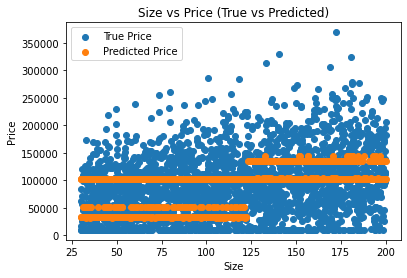

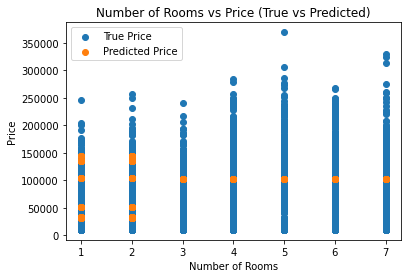

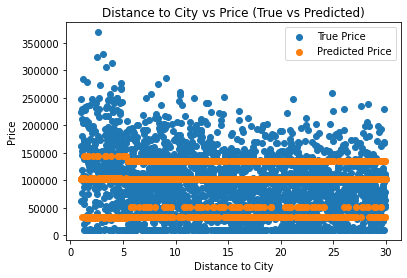

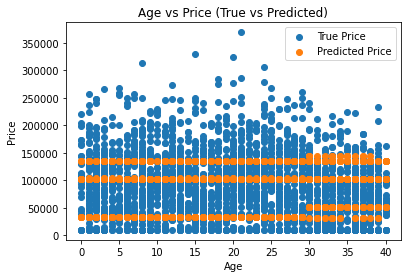

In [91]:
plot_feature_vs_price(test_local, 0, "Size")
plot_feature_vs_price(test_local, 1, "Number of Rooms")
plot_feature_vs_price(test_local, 2, "Distance to City")
plot_feature_vs_price(test_local, 3, "Age")